In [1]:
import pandas as pd 

# thư viên bắt buộc 
from pandas_datareader.data import DataReader

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ cho ngầu 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM
# phải cài cái này 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
# Read the CSV file and set 'Date' as the index
df = pd.read_csv('Apple_Stock_Prices.csv')
df.set_index('Date', inplace=True)

# Convert the 'Date' index to datetime format
df.index = pd.to_datetime(df.index, dayfirst=True)

# Filter the DataFrame 
start_date = '2005/02/01'
end_date = '2023/01/27'
mask = (df.index >= start_date) & (df.index <= end_date)
df_filtered = df.loc[mask]
df_filtered


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-02-01,1.375893,1.388750,1.367500,1.384464,1.180142,678395200
2005-02-02,1.391964,1.426964,1.387321,1.421964,1.212108,1020062400
2005-02-03,1.412500,1.418393,1.380893,1.389464,1.184404,731651200
2005-02-04,1.390536,1.409464,1.384464,1.407857,1.200083,563556000
2005-02-07,1.409464,1.416964,1.383929,1.409643,1.201605,524456800
...,...,...,...,...,...,...
2023-01-23,138.119995,143.320007,137.899994,141.110001,141.110001,81760300
2023-01-24,140.309998,143.160004,140.300003,142.529999,142.529999,66435100
2023-01-25,140.889999,142.429993,138.809998,141.860001,141.860001,65799300


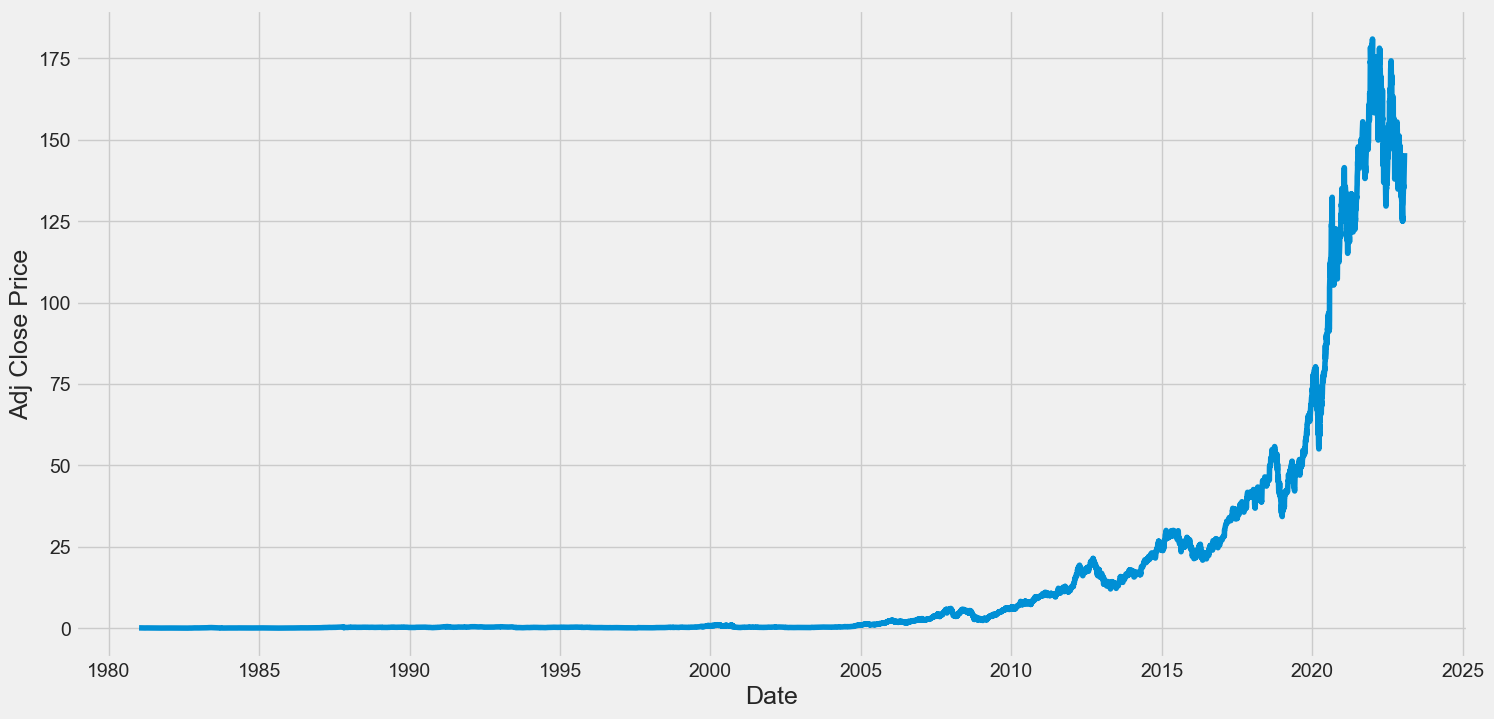

In [3]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.show()

In [4]:
# Chia tập dữ liệu để làm việc
def splitDataset(df):
    length = df.shape[0]
    sixtyPercent = length * 60 // 100
    eightyPercent = length * 80 // 100
    train_df = df[:sixtyPercent]
    val_df = df[sixtyPercent:eightyPercent]
    test_df = df[eightyPercent:]
    return train_df, val_df, test_df

train_df, val_df, test_df = splitDataset(df)

train_df.shape, val_df.shape, test_df.shape

((6364, 6), (2122, 6), (2122, 6))

In [5]:
# Tiền xử lý tập train và tạo preprocess_pipeline
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Adj Close'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(6364, 1)

In [6]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape

(6364,)

In [7]:
# tạo dữ liệu train_X và train_y
def createTrainX_y(scaled_train_data, time_steps=60, out_length=1):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y(scaled_train_data)
train_X.shape, train_y.shape

((6304, 60, 1), (6304, 1))

In [8]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y)),
])

train_X, train_y = preprocess_pipeline.fit_transform(train_df)
train_X.shape, train_y.shape

((6304, 60, 1), (6304, 1))

In [9]:
# Tạo model 
def createModel(train_X, time_steps=60, out_length=1):
    model = Sequential()
    model.add(LSTM(60, activation='tanh', return_sequences=False, input_shape=(train_X.shape[1], 1)))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [10]:
# xử lý tập validation
# tạo tập inputs
val_inputs = df[len(df) - len(val_df) - 60:]
val_X, val_y = preprocess_pipeline.transform(val_inputs)
val_X.shape, val_y.shape

((2122, 60, 1), (2122, 1))

In [11]:
# thử nhiều tham số epochs để tìm ra model tốt nhất
epochs_ = [1,2,3,4,5,6]
best_val_err = float('inf')
best_epoch = None

for e in epochs_:
    # build model 
    model = createModel(train_X)
    model.fit(train_X, train_y, batch_size=1, epochs=e)

    # dự đoán tập inputs
    pred_val = model.predict(val_X)
    pred_val = preprocess_pipeline.inverse_transform(pred_val)

    val_df['Predict'] = pred_val
    mse = np.sqrt(np.mean(((val_df['Predict'] - val_df['Adj Close']) ** 2)))
    if mse < best_val_err:
        best_val_err = mse 
        best_epoch = e
        print(e, mse)

67/67 [==============================] - 6s 21ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_37188\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


1 7.686907624050063
Epoch 1/2
6304/6304 [==============================] - 169s 26ms/step - loss: 2.6598e-04
Epoch 2/2
67/67 [==============================] - 2s 14ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_37188\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/3
6304/6304 [==============================] - 105s 16ms/step - loss: 4.2131e-04
Epoch 2/3
6304/6304 [==============================] - 101s 16ms/step - loss: 1.1829e-04
Epoch 3/3
67/67 [==============================] - 2s 18ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_37188\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/4
6304/6304 [==============================] - 141s 22ms/step - loss: 4.6950e-04
Epoch 2/4
6304/6304 [==============================] - 165s 26ms/step - loss: 1.3479e-04
Epoch 3/4
6304/6304 [==============================] - 182s 29ms/step - loss: 8.0724e-05
Epoch 4/4
67/67 [==============================] - 4s 25ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_37188\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/5
6304/6304 [==============================] - 195s 30ms/step - loss: 2.8746e-04
Epoch 2/5
6304/6304 [==============================] - 184s 29ms/step - loss: 1.1057e-04
Epoch 3/5
6304/6304 [==============================] - 197s 31ms/step - loss: 7.9734e-05
Epoch 4/5
6304/6304 [==============================] - 183s 29ms/step - loss: 7.3536e-05
Epoch 5/5
67/67 [==============================] - 4s 23ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_37188\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


Epoch 1/6
6304/6304 [==============================] - 187s 29ms/step - loss: 2.1657e-04
Epoch 2/6
6304/6304 [==============================] - 172s 27ms/step - loss: 9.6275e-05
Epoch 3/6
6304/6304 [==============================] - 156s 25ms/step - loss: 8.3020e-05
Epoch 4/6
6304/6304 [==============================] - 159s 25ms/step - loss: 7.5599e-05
Epoch 5/6
6304/6304 [==============================] - 159s 25ms/step - loss: 6.1649e-05
Epoch 6/6
67/67 [==============================] - 3s 21ms/step
6 6.649645127889475


C:\Users\DELL\AppData\Local\Temp\ipykernel_37188\304041015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Predict'] = pred_val


In [19]:
# fit model với tập train và predict tập test
# tạo dữ liệu train để fit (bao gồm train_df và valid_df)
train_inputs = df[:len(df) - len(test_df) - 60]
train_X, train_y = preprocess_pipeline.fit_transform(train_inputs)

# build model 
model = createModel(train_X)
model.fit(train_X, train_y, batch_size=1, epochs=best_epoch)

Epoch 1/6
8366/8366 [==============================] - 120s 14ms/step - loss: 2.4605e-04
Epoch 2/6
8366/8366 [==============================] - 140s 17ms/step - loss: 9.0005e-05
Epoch 3/6
8366/8366 [==============================] - 151s 18ms/step - loss: 6.1186e-05
Epoch 4/6
8366/8366 [==============================] - 137s 16ms/step - loss: 5.8503e-05
Epoch 5/6
8366/8366 [==============================] - 151s 18ms/step - loss: 5.4021e-05
Epoch 6/6
8366/8366 [==============================] - 153s 18ms/step - loss: 4.6754e-05


In [13]:
# tạo dữ liệu test 
test_inputs = df[len(df) - len(test_df) - 60:]
test_X, test_y = preprocess_pipeline.transform(test_inputs)

# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = preprocess_pipeline.inverse_transform(pred_test)

67/67 [==============================] - 2s 12ms/step


In [14]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = preprocess_pipeline.inverse_transform(pred_test)
pred_test.shape

67/67 [==============================] - 1s 12ms/step


(2122, 1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_37188\1515979675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = pred_test


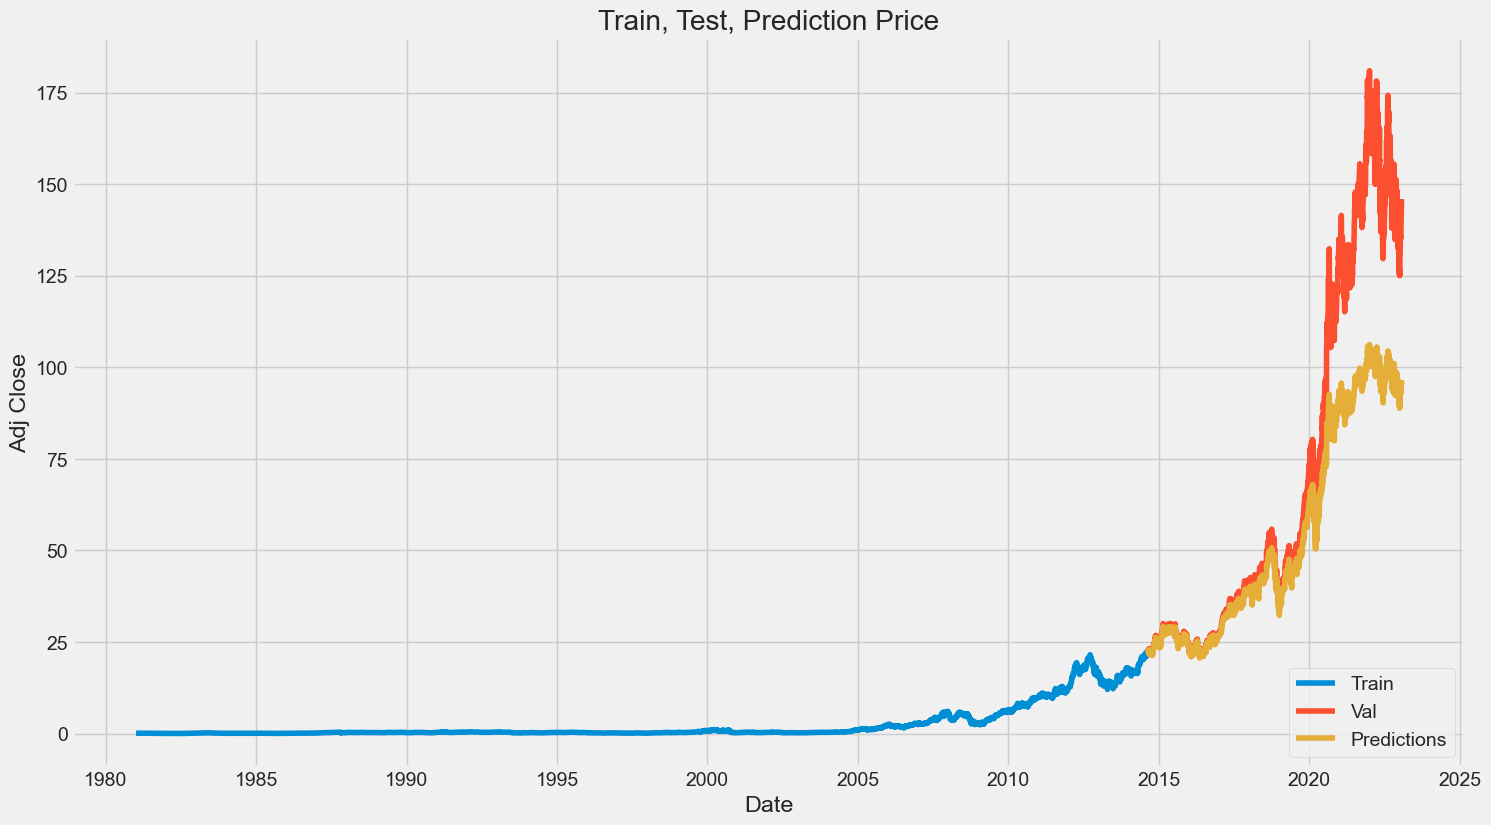

In [15]:
# vẽ đồ thị phần train, test và predict 
length = df.shape[0]
eightyPercent = length * 80 // 100
train = df[:eightyPercent]
test = df[eightyPercent:]
test['Predictions'] = pred_test

plt.figure(figsize=(16,9))
plt.title('Train, Test, Prediction Price')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [16]:
test

,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2014-08-25,25.447500,25.542500,25.320000,25.385000,22.751516,161080000,22.403299
2014-08-26,25.355000,25.375000,25.215000,25.222500,22.605873,132608000,22.436211
2014-08-27,25.254999,25.642500,25.174999,25.532499,22.883717,209476000,22.266354
2014-08-28,25.397499,25.695000,25.389999,25.562500,22.910601,273840000,22.600828
2014-08-29,25.715000,25.725000,25.549999,25.625000,22.966619,178380000,22.595182
...,...,...,...,...,...,...,...
2023-01-23,138.119995,143.320007,137.899994,141.110001,141.110001,81760300,94.440186
2023-01-24,140.309998,143.160004,140.300003,142.529999,142.529999,66435100,95.437561
2023-01-25,140.889999,142.429993,138.809998,141.860001,141.860001,65799300,95.670113


In [17]:
mse = np.sqrt(np.mean((test['Adj Close'] - test['Predictions']) ** 2))
print(mse)

26.652150430735873
